This notebook will be used to compare the tidal ellipses from the model outputs to the ones generated by Mike Foreman's model in Foreman et al. (2004).

In [2]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [40]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

##Loading Data
7 months of data takes a long time to compile therefore the paramters have been saved into files in this [notebook](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/SaveTidalParameters.ipynb). In the cells below we will load the ellipse parameters into a matrix with all the M2 and K1 parameters at Haro Strait, Juan de Fuca West and Eastm Johnstone Strait and at Arran Rapids.

In [1]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 21)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

loc = ['JuanW','JC', 'JuanE', 'Haro', 'NN', 'TS','TN', 'JS', 'AR']
count = np.arange(0,8)
params = np.zeros((8,39,5))
params_av = np.zeros((8,8))
cols=np.arange(0,5)

for i,j in zip(loc,count):
    runname1 = '{}_{}_{}'.format(t_o, t_f, i)
    runname2 = '{}_{}_{}_depav(20-200)'.format(t_o, t_f, i)
    df1 = pd.read_csv(runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv(runname2+'.csv', index_col=False)
    params[j,:,:] = df1.as_matrix()
    params_av[j,:] = df2.as_blocks(6)


NameError: name 'datetime' is not defined

##The Foreman Locations

In [171]:
#Haro Strait
iH = 233
jH = 312

#Juan de Fuca West
iJW=3
jJW=405

#Juan de Fuca East
iJE = 147
jJE = 276

#Johnstone Strait
iJS = 58
jJS = 885

#Arran Rapids
iAR = 194
jAR = 811

##Adding Thalweg locations as well...

In [172]:
#Between East and Wast Juan de Fuca
iJC = 100
jJC = 315

#Near the ONC VENUS nodes
iNN = 262
jNN = 450

#Texada South
iTS = 187
jTS = 550

#Texada North 
iTN = 155
jTN = 675



(898, 398)
red is clockwise


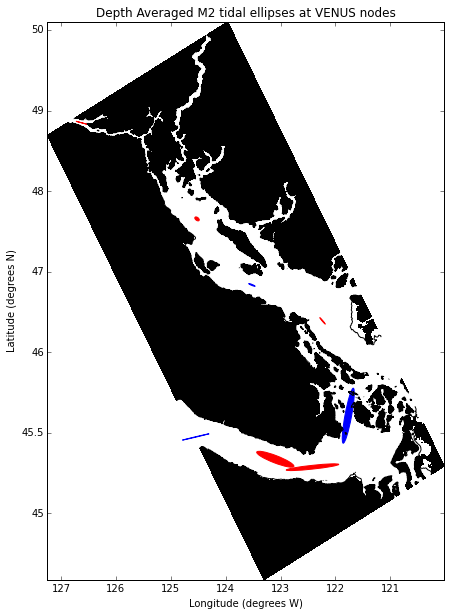

In [174]:
phi=29
fig = plt.figure(figsize=(10,10))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 2

imin=3
imax = 333

jmin = 176
jmax = 895

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
scale = 100
dep=10

#Making the ellipse for the Central node

count = np.arange(0,8)
i = (iJW, iJC, iJE, iH, iNN, iTS, iTN, iJS, iAR)
j = (jJW, jJC, jJE, jH, jNN, jTS, jTN, jJS, jAR)

for loc, i, j in zip(count, i ,j):
    if params[loc,dep,2] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[j,i],k[j,i]), width=scale*params[loc,dep,1], 
                        height=scale*params[loc,dep,2], angle=params[loc, dep,3],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
#ax.set_ylim(300,350)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(44, 50, 0.5)-
                           lats[jmin,imin])/slope).tolist()
labels = ['44.5','45','45.5','46','47','48', '49','50']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
#ax.set_xlim(100,120)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-127,-120.5,1)-
                        lons[jmin,imin])/slope).tolist()
labels = ['127','126','125','124','123','122','121', '120']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')
print bathy.data.shape

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at VENUS nodes')

print "red is clockwise"

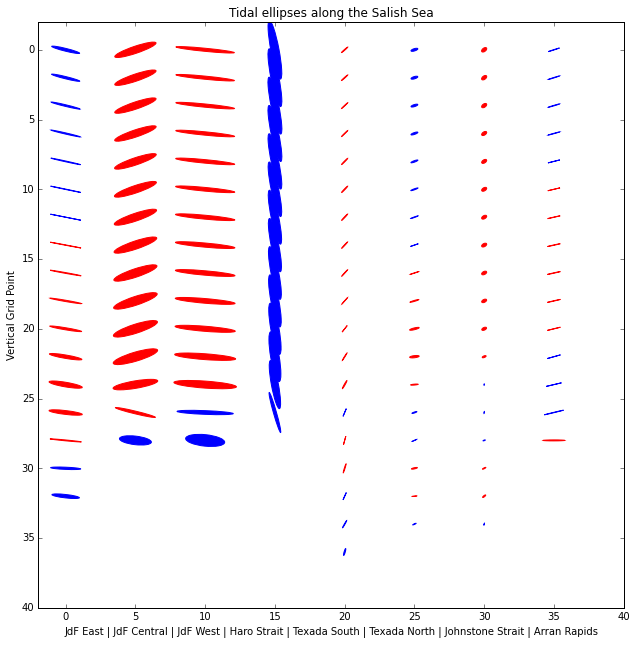

In [180]:
fig = plt.figure(figsize=(10.5,10.5))
ax = fig.add_subplot(111)
scale = 5
interval = 2

for loc in np.arange(0,8):
    for dep in np.arange(0,40,interval):
        if params[loc,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(loc*5,dep), width=scale*params[loc,dep,1], 
                            height=scale*params[loc,dep,2], angle=params[loc,dep,3],
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)

ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,40)
ax.set_title('Tidal ellipses along the Salish Sea')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('JdF East | JdF Central | JdF West | Haro Strait | Texada South | Texada North | Johnstone Strait | Arran Rapids')